<a href="https://colab.research.google.com/github/trankha1655/CS114_ML/blob/main/Colab_Research/Bai_tap_colab_so_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BÀI TẬP COLAB SỐ 04 - NHẬN DIỆN TRANG BÁO CHÂM BIẾM BẰNG TIÊU ĐỀ BÀI BÁO

---


**Lớp CS114.L21**

Nhóm:


1.   Trần Phan Nhật Kha - 19521655
2.   Trần Gia Nghĩa - 19521901
3.   Võ Tá Lâm - 1952174419521744

Tham khảo:

1.   [Sarcasm detection with word2vec and glove](https://www.kaggle.com/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy)
2.   [Xử lý ngôn ngữ tự nhiên với Python](https://viblo.asia/s/xu-ly-ngon-ngu-tu-nhien-voi-python-Je5Ejz9wKnL)
3.   [Working With Text Data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#building-a-pipeline)

#**LOADING THE NECESSARY LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns # Hỗ trợ vẽ biểu đồ
import nltk #Thư viện xử lý ngôn ngữ tự nhiên
import string # Các phép toán chuỗi thông thường
import re #Các phép toán biểu thức chính quy cho chuỗi
from nltk.corpus import stopwords #Stop words cho các ngôn ngữ phổ biến
from nltk.tokenize import word_tokenize #Tách từ từ một chuỗi
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet #Cơ sở dữ liệu từ vựng cho tiếng Anh
from sklearn.feature_extraction.text import CountVectorizer #Tokenizing text
from sklearn.feature_extraction.text import TfidfTransformer #Thuật toán tf-idf
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import metrics #Report

In [ ]:
!git clone https://github.com/trankha1655/CS114_ML.git #Liên kết đến repository github
data_train = pd.read_json("/content/CS114_ML/Colab_Research/Bai_Tap_Colab_So_4/dataset-news-is_sarcastic.json", lines=True)
data_train = data_train.sample(frac=1).reset_index(drop=True) #Xáo trộn bộ dữ liệu
data_train.head()

fatal: destination path 'CS114_ML' already exists and is not an empty directory.


,article_link,headline,is_sarcastic
0,https://www.newyorker.com//humor/borowitz-repo...,Trump Says Supreme Court Nominee Will Be Woman...,1
1,https://toronto.citynews.ca/2018/01/09/n-s-say...,N.S. premier seeks review as former foster chi...,0
2,https://www.euronews.com//travel/2020/01/28/du...,Dubai Creek: Discover a lost Arabian world,0
3,https://www.euronews.com//2021/03/19/in-ukrain...,"In Ukraine, Stepan Bandera’s legacy becomes a ...",0
4,https://www.newyorker.com//cartoons/daily-cart...,Bonus Daily Cartoon: Gun Reform,1


In [ ]:
data_test = pd.read_json("/content/CS114_ML/Colab_Research/Bai_Tap_Colab_So_4/Data for test from Kaggle/Sarcasm_Headlines_Dataset.json", lines=True)
data_test = data_test.sample(frac=1).reset_index(drop=True) #Xáo trộn bộ dữ liệu
data_test.head()

,article_link,headline,is_sarcastic
0,https://entertainment.theonion.com/comics-not-...,"comics not just for kids anymore, reports 85,0...",1
1,https://www.theonion.com/attorney-client-privi...,"attorney, client privileged",1
2,https://www.theonion.com/stephen-hawking-warns...,stephen hawking warns about dangers of ai as m...,1
3,https://www.huffingtonpost.com/entry/facebook-...,facebook recognizes everyone needs paid time o...,0
4,https://local.theonion.com/man-forced-to-come-...,man forced to come up with 45 seconds of facia...,1


#**DATA VISUALIZATION AND PREPROCESSING**

##**DATA VISUALIZATION**

###Data training

In [ ]:
data_train.isna().sum() #Kiểm tra giá trị trống trong dataframe

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [ ]:
del data_train['article_link'] # Xóa cột không cần thiết
data_train

,headline,is_sarcastic
0,Trump Says Supreme Court Nominee Will Be Woman...,1
1,N.S. premier seeks review as former foster chi...,0
2,Dubai Creek: Discover a lost Arabian world,0
3,"In Ukraine, Stepan Bandera’s legacy becomes a ...",0
4,Bonus Daily Cartoon: Gun Reform,1
...,...,...
78229,Conservative party pulls attack ad of black ma...,0
78230,Watch: Chester Zoo has been saved by a campaig...,0
78231,"Curling-Women's world championship back on, ...",0
78232,Chicago Mayor Says Fourth Of July Weekend Was ...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


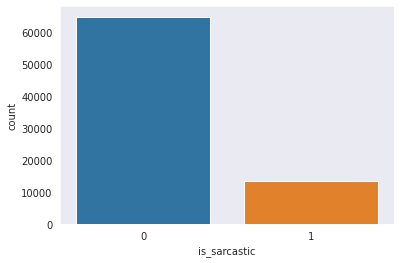

In [ ]:
sns.set_style("dark")
sns.countplot(data_train.is_sarcastic)

Qua biểu đồ trên, số lượng bài báo chính thông và châm biếm có sự chênh lệch tương đối lớn. Trong đó bài báo chính thống có hơn 60000 bài (Chiếm tỉ lệ 83%) và bài báo châm biếm có hơn 10000 bài (chiếm tỉ lệ 17%). Tổng cộng có 78234 bài báo của cả 2 loại (Đã được nhận xét trong phần thu thập dữ liệu).

###Data testing

Nguồn: https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection?select=Sarcasm_Headlines_Dataset.json

In [ ]:
data_test.isna().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [ ]:
del data_test['article_link'] # Xóa cột không cần thiết
data_test

,headline,is_sarcastic
0,"comics not just for kids anymore, reports 85,0...",1
1,"attorney, client privileged",1
2,stephen hawking warns about dangers of ai as m...,1
3,facebook recognizes everyone needs paid time o...,0
4,man forced to come up with 45 seconds of facia...,1
...,...,...
26704,watch bryan cranston's 'malcolm in the middle'...,0
26705,papa john's comes under fire for cruel treatme...,1
26706,how to survive in a conspiracy theorist's world,0
26707,bad news: appointment of shia militiaman to ir...,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


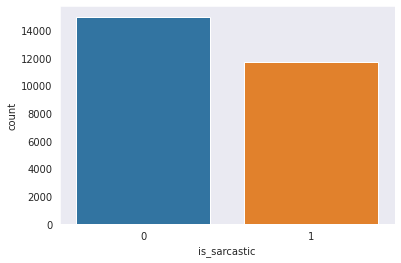

In [ ]:
sns.set_style("dark")
sns.countplot(data_test.is_sarcastic)

Dữ liệu test được lấy trên kaggle có sự chênh lệch không quá lớn giữa các bài báo chính thống và các bài báo châm biếm. Có 11724 trang báo châm biếm và 14985 trang báo chính thống.

##**DATA PREPROCESSING**

**Stopwords** là những từ tiếng Anh không bổ sung nhiều ý nghĩa cho một câu. Chúng có thể được bỏ qua mà không làm mất đi ý nghĩa của câu. Ví dụ, những từ như: *the*, *he*, *have*,v.v.

In [ ]:
 #Download bộ dữ liệu cần thiết
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

stop = set(stopwords.words('english')) #Sử dụng dữ liệu dành cho tiếng Anh
punctuation = list(string.punctuation) # Mảng các dấu bao gồm (!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~)
punctuation.extend(["'s",'‘','’','“','”'])
#punctuation.append("'s") #Thêm sở hữu cách của tiếng Anh
stop.update(punctuation) #Thêm các dấu câu ở trên vào bộ dữ liệu stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
stop

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 "'s",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',

###DATA CLEANING

Các phương pháp xử lý dữ liệu được áp dụng:

*   Xóa dấu
*   Xóa khoảng trắng ở đầu, giữa và cuối câu
*   Tìm các từ gốc của một từ
*   Xóa các chữ số vì các chữ số không ảnh hưởng nhiều đến kết quả phân loại
*   Xóa các stopwords đã được định nghĩa ở trên

In [ ]:
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Hàm chuyển text về dạng chữ viết thường
def text_lowercase(text):
  return text.lower()

lem = WordNetLemmatizer()

#tìm ra các tag từ thông dụng
def nltk2wn_tag(nltk_tag):
  if nltk_tag.startswith('J'):
    return wordnet.ADJ
  elif nltk_tag.startswith('V'):
    return wordnet.VERB
  elif nltk_tag.startswith('N'):
    return wordnet.NOUN
  elif nltk_tag.startswith('R'):
    return wordnet.ADV
  else:                    
    return None

#hàm Tìm từ gốc của cả một câu.
def lemmatizer(sentence):
  #tìm ra các pos tag của các từ trong câu
  nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))    
  wn_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)

  #biến đổi từng từ và trả về câu với các từ được biến đổi
  res_words = []
  #nếu không tìm được nhãn từ loại của từ (pos-tag) thì trả về chính từ đó
  for word, tag in wn_tagged:
    if tag is None:                        
      res_words.append(word)
    else:
      res_words.append(lem.lemmatize(word, tag))

  return " ".join(res_words)

#Xóa khoảng trắng
def remove_whitespace(text):
  return " ".join(text.split())

#Xóa số
def remove_number(text):
  return re.sub(r'\d+', '', text)

#Xóa stopwords
def remove_stopwords(text):
  word_tokens = word_tokenize(text)
  filtered_text = [word for word in word_tokens if word not in stop]
  return filtered_text

def preprocessing(text):
  text = remove_between_square_brackets(text)
  text = text_lowercase(text)
  text = lemmatizer(text)
  text = remove_whitespace(text)
  text = remove_number(text)
  text = remove_stopwords(text)
  return text

def convert_list_to_string(list):
  return ' '.join([str(elem) for elem in list])

df1_train = data_train.copy(deep=True)
df1_test = data_test.copy(deep=True)
df1_train['headline'] = df1_train['headline'].apply(preprocessing)
df1_train['headline'] = df1_train['headline'].apply(convert_list_to_string)
df1_test['headline'] = df1_test['headline'].apply(preprocessing)
df1_test['headline'] = df1_test['headline'].apply(convert_list_to_string)

In [ ]:
df1_train

,headline,is_sarcastic
0,trump say supreme court nominee woman person c...,1
1,n.s premier seek review former foster child fa...,0
2,dubai creek discover lost arabian world,0
3,ukraine stepan bandera legacy become political...,0
4,bonus daily cartoon gun reform,1
...,...,...
78229,conservative party pull attack ad black man wa...,0
78230,watch chester zoo save campaign social medium,0
78231,curling-women world championship back hold cal...,0
78232,chicago mayor say fourth july weekend 'mostly ...,1


In [ ]:
df1_test

,headline,is_sarcastic
0,comic kid anymore report th mainstream news story,1
1,attorney client privilege,1
2,stephen hawk warns danger ai motorized wheelch...,1
3,facebook recognize everyone need pay time parent,0
4,man force come second facial expression waitre...,1
...,...,...
26704,watch bryan cranston 'malcolm middle character...,0
26705,papa john come fire cruel treatment bulbous de...,1
26706,survive conspiracy theorist world,0
26707,bad news appointment shia militiaman iraqi cab...,0


##**TRAINING MODEL AND TESTING**

###TRAINING WITH VECTOR SPACE MODEL

####Tokenizing text and apply tf-idf



CountVectorizer hỗ trợ xử lý trước văn bản, mã hóa và lọc stop words, giúp xây dựng từ điển các tính năng và chuyển đổi tài liệu thành vectơ đặc trưng:

In [ ]:
count_vect_train = CountVectorizer()

x_train = count_vect.fit_transform(df1_train['headline'])
x_test = count_vect.transform(df1_test['headline'])

print("Shape of x_train:",x_train.shape)
print("Shape of x_test",x_test.shape)

Shape of x_train: (78234, 27556)
Shape of x_test (26709, 27556)


TF-IDF là một trong những kỹ thuật cơ bản trong xử lý ngôn ngữ giúp đánh giá mức độ quan trọng của một từ trong văn bản.


*   TF(Term frequency) : Tần suất xuất hiện của 1 từ trong 1 document.
*   IDF( Invert Document Frequency) : Dùng để đánh giá mức độ quan trọng của 1 từ trong văn bản. Khi tf tính mức độ quan trọng của các từ là như nhau. Tuy nhiên trong văn bản thường xuất hiện nhiều từ không quan trọng xuất hiện với tần suất cao. Chính vì thế ta cần giảm đi mức độ quan trọng của những từ đó bằng IDF.



In [ ]:
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train)
x_test_tfidf = tfidf_transformer.transform(x_test)
y_train = df1_train['is_sarcastic']
y_test = df1_test['is_sarcastic']
print('Shape of x_train_tfidf:',x_train_tfidf.shape)
print('Shape of x_test_tfidf:',x_test_tfidf.shape)

Shape of x_train_tfidf: (78234, 27556)
Shape of x_test_tfidf: (26709, 27556)


####Classification with naïve Bayes classifier

In [ ]:
clf_1 = MultinomialNB().fit(x_train_tfidf,y_train)
y_pred_1 = clf_1.predict(x_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.61      0.74      0.67     14985
           1       0.54      0.39      0.45     11724

    accuracy                           0.59     26709
   macro avg       0.57      0.57      0.56     26709
weighted avg       0.58      0.59      0.57     26709



In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_1))

Accuracy: 0.5860945748624059


#### Classification with SVM

In [ ]:
clf_2 = SGDClassifier().fit(x_train_tfidf,y_train)
y_pred_2 = clf_2.predict(x_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.63      0.74      0.68     14985
           1       0.57      0.45      0.50     11724

    accuracy                           0.61     26709
   macro avg       0.60      0.59      0.59     26709
weighted avg       0.61      0.61      0.60     26709



In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_2))

Accuracy: 0.6117039200269572


#**Nhận xét:**

Tỉ lệ dự đoán chính xác của 2 model trên là không cao vì các nguyên nhân sau đây:



*   Sự bất cân xứng dữ liệu huấn luyện và dữ liệu kiểm thử. Dữ liệu huấn luyện có sự chênh lệch giữa bài báo chính thống và bài báo châm biếm là rất lớn, còn bộ dữ liệu kiểm thử lại có số lượng 2 nhãn là như nhau.
*   Do quá trình xử lý dữ liệu chưa thật sự tốt
*   Các bài báo chủ yếu được lấy trong 3 năm gần đây nên xuất hiện rất nhiều từ phổ biến trong các tiêu đề được lặp đi lặp lại (vd: covid, trump,...)
*   Tựa đề các bài báo tương đối ngắn nên việc dùng các phương pháp đếm số lần xuất hiện không hiệu quả



